# NASA JPL ECCO Data

Notebook credit:
- Chelle Gentemann
- Greg Niemeyer 

NASA’s Estimating the Circulation and Climate of the Ocean (ECCO) project supports climate research by providing the scientific community with the best possible multidecadal reconstructions of Earth’s time-evolving full-depth ocean, sea-ice, and atmospheric surface states and their associated fluxes.

ECCO state estimate are multi-platform, multi-instrument, multi-variable synthesis products that integrate global satellite and in-situ ocean and ice observations with coupled ocean/sea-ice models. By construction, ECCO state estimates satisfy the laws of physics and thermodynamics and therefore conserve heat, salt, volume, and momentum. This strict adherence to conservation principles makes ECCO products particularly well-suited for investigations into the origins of observed ocean, sea-ice, and sea-level variability.

The project brings together diverse data streams, including satellite observations (e.g., sea level from the Jason-series satellite altimeters and ocean bottom pressure from the GRACE and GRACE-Follow On missions) and in situ measurements (e.g., temperature and salinity profiles from Argo floats and CTDs) to obtain the best possible estimate of the time evolving ocean circulation and related uncertainties.

- [https://science.jpl.nasa.gov/projects/ecco/](https://science.jpl.nasa.gov/projects/ecco/)
- [https://podaac.jpl.nasa.gov/ECCO](https://podaac.jpl.nasa.gov/ECCO)

ECCO data include:'Eta', 'KPPhbl', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX','oceTAUY', 'PhiBot', 'Salt', 'SIarea', 'SIheff', 'SIhsalt', 'SIhsnow', 'SIuice','SIvice', 'Theta', 'U','V','W'

Since the complete ECCO V4r4 product exceeds 3TB across more than 385,000 granules (!!!), in this notebook, we don't download the large ECCO files. Instead, we access them through the ECCO data portal, using Xarray and lazy loading to only get the data we need.

Steps -
- connect to model data in portal
- get dataset name and read a small portion of the data
- create the downward and upward profiles and link them together
- print a figure of the profile and save the data as a dataframe


In [1]:
import numpy as np
import xarray as xr
import xmitgcm.llcreader as llcreader
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

#3D plot
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (10,10)

In [ ]:
model = llcreader.ECCOPortalLLC2160Model()
ds = model.get_dataset(varnames=['Salt'], type='latlon')

down_lat = 25.6
down_lon = -79.48
down_ilat = abs(ds.YC[:,0] - down_lat).argmin()
down_ilon = abs(ds.XC[0,:] - down_lon).argmin()

up_lat = 25.6
up_lon = -79.81
up_ilat = abs(ds.YC[:,0] - up_lat).argmin()
up_ilon = abs(ds.XC[0,:] - up_lon).argmin()

down_ilat, down_ilon = down_ilat.load(),down_ilon.load()
up_ilat, up_ilon = up_ilat.load(),up_ilon.load()


In [ ]:

print(down_ilat,down_ilon.value)


In [17]:
down_lat = 19.71361111111111
down_lon = -67.31083333333333
down_ilat = abs(ds.YC[:,0] - set_lat).argmin()
down_ilon = abs(ds.XC[0,:] - set_lon).argmin()

print(ilat.load())

<xarray.DataArray 'YC' ()> Size: 8B
np.int64(4482)
Coordinates:
    i        int64 8B 0


In [ ]:
## read in 3D data from public portal (you don't have to download!)
model = llcreader.ECCOPortalLLC2160Model()
ds = model.get_dataset(varnames=['Salt'], type='latlon')
subset2 = ds.isel(time=-1,j=slice(down_ilat-2,down_ilat+2),i=slice(down_ilon-2,down_ilat+2))
array2 = xr.DataArray(subset2.Salt.data,dims=['depth','lat','lon'],coords={'depth':subset2.Z.data,'lat':subset2.YC[:,0].data,'lon':subset2.XC[0,:].data})
#array2 = array2.load()

In [ ]:
down_data = array2.sel(lat=25.6,lon= -79.48,method='nearest')
down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=25.6,lon=-79.81,method='nearest')
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32

i1=0; i2=48;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,5400)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

i1=0; i2=47;
tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

i1=0; i2=101;
tem = down_data2[i1:i2].copy()
depth_new=np.linspace(down_data2.depth[-1].data,up_data2.depth[-1].data,101)
#temp_new=np.linspace(down_lowest,up_lowest.data,101)
temp_new=np.linspace(down_lowest,up_lowest,101)
middle_data = tem
middle_data['depth']=depth_new #set depth all to deepest point
middle_data[:]=temp_new #set temp to lowest temp

In [ ]:
data_bottom_pause = xr.concat(
    [down_data2,middle_data,up_data2.isel(depth=slice(None, None, -1))],
    dim='depth')
df = data_bottom_pause.to_dataframe()
# Find columns that contain the string 'getitem'
matching_columns = [col for col in df.columns if 'getitem' in col]
df = df.rename(columns={matching_columns[0]:'Salinity'})
df['depth']=df.index
#df['timestep'] = np.arange(7200)
df.index=np.arange(7200)
df.index.name = 'timestep'
#df = df[['timestep', 'depth','Theta', 'lat', 'lon']]
df = df[['depth','Salinity', 'lat', 'lon']]
#del df['lat']
#del df['lon']
#save data
df.to_csv("./data/data_bottom_pause_Salt.csv")
del df['lat']
del df['lon']
#save data
df.to_csv("./data/data_bottom_pause_Salt_nolatlon.csv")
df_save = df

In [ ]:
plt.figure(figsize=(5, 3))
#plt.plot(np.arange(0,5400),down_data2.data,color='blue')
#tem = middle_data
#plt.plot(np.arange(0,101)+5400,tem,color='black')
#tem = up_data2.isel(depth=slice(None, None, -1))
#plt.plot(np.arange(0,1699)+5501,tem,color='green')
df = pd.read_csv("./data/data_bottom_pause_Salt_nolatlon.csv")
plt.plot(df.index,df.Salinity)
plt.xlabel('Timestep')
plt.ylabel('Salt')
#plt.text(4000, 36.5, "Down", color="blue", fontsize=12)
#plt.text(4000, 36.3, "Up", color="green", fontsize=12)
#plt.text(4000, 36.1, "Pause", color="black", fontsize=12)
plt.savefig('./figures/ecco-salt-profile')

# now do temperature (theta)
-restart your kernel!

In [4]:
model = llcreader.ECCOPortalLLC2160Model()
ds = model.get_dataset(varnames=['Theta'], type='latlon')
subset2 = ds.isel(time=-1,j=slice(4645,4655),i=slice(7640,7650),k=slice(0,50))
array2 = xr.DataArray(subset2.Theta.data,dims=['depth','lat','lon'],coords={'depth':subset2.Z.data,'lat':subset2.YC[:,0].data,'lon':subset2.XC[0,:].data})
#array2 = array2.load()

In [5]:
down_data = array2.sel(lat=25.6,lon= -79.48,method='nearest')
down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=25.6,lon=-79.81,method='nearest')
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32

i1=0; i2=48;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,5400)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

i1=0; i2=47;
tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

i1=0; i2=101;
tem = down_data2[i1:i2].copy()
depth_new=np.linspace(down_data2.depth[-1].data,up_data2.depth[-1].data,101)
#temp_new=np.linspace(down_lowest,up_lowest.data,101)
temp_new=np.linspace(down_lowest,up_lowest,101)
middle_data = tem
middle_data['depth']=depth_new #set depth all to deepest point
middle_data[:]=temp_new #set temp to lowest temp

In [6]:
data_bottom_pause = xr.concat(
    [down_data2,middle_data,up_data2.isel(depth=slice(None, None, -1))],
    dim='depth')
df = data_bottom_pause.to_dataframe()
# Find columns that contain the string 'getitem'
matching_columns = [col for col in df.columns if 'getitem' in col]
df = df.rename(columns={matching_columns[0]:'Theta'})
df['depth']=df.index
#df['timestep'] = np.arange(7200)
df.index=np.arange(7200)
df.index.name = 'timestep'
#df = df[['timestep', 'depth','Theta', 'lat', 'lon']]
df = df[['depth','Theta', 'lat', 'lon']]
#save data
df.to_csv("./data/data_bottom_pause_Theta.csv")
del df['lat']
del df['lon']
#save data
df.to_csv("./data/data_bottom_pause_Theta_nolatlon.csv")
df

,depth,Theta
timestep,,
0,-0.500000,26.478880
1,-0.650428,26.479834
2,-0.800856,26.480785
3,-0.951284,26.481739
4,-1.101711,26.482691
...,...,...
7195,-2.314099,26.628878
7196,-1.860574,26.627817
7197,-1.407049,26.626160


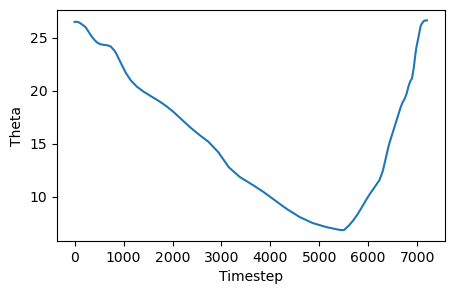

In [8]:
plt.figure(figsize=(5, 3))
df = pd.read_csv("./data/data_bottom_pause_Theta_nolatlon.csv")
plt.plot(df.index,df.Theta)
plt.xlabel('Timestep')
#plt.plot(np.arange(0,5400),down_data2.data,color='blue')
#tem = middle_data
#plt.plot(np.arange(0,101)+5400,tem,color='black')
#tem = up_data2.isel(depth=slice(None, None, -1))
#plt.plot(np.arange(0,1699)+5501,tem,color='green')
plt.ylabel('Theta')
#plt.xlabel('Index')
#plt.text(4000, 25, "Down", color="blue", fontsize=12)
#plt.text(4000, 23, "Up", color="green", fontsize=12)
#plt.text(4000, 21, "Pause", color="black", fontsize=12)
plt.savefig('./figures/ecco-theta-profile')

In [9]:
df_save = pd.read_csv("./data/data_bottom_pause_Salt_nolatlon.csv")
df_save['Theta'] = df['Theta']
df_save.to_csv("./data/data_bottom_pause_ThetaSalt_nolatlon.csv")

# now do velocities
- restart your kernel

In [2]:
model = llcreader.ECCOPortalLLC2160Model()
ds = model.get_dataset(varnames=['U','V'], type='latlon')
subset2 = ds.isel(time=-1,j=slice(4645,4655),j_g=slice(4645,4655),i=slice(7640,7650),i_g=slice(7640,7650),k=slice(0,50))
array2 = xr.DataArray(subset2.U.data,dims=['depth','lat','lon'],coords={'depth':subset2.Z.data,'lat':subset2.YC[:,0].data,'lon':subset2.XC[0,:].data})
#array3 = xr.DataArray(subset2.V.data,dims=['depth','lat','lon'],coords={'depth':subset2.Z.data,'lat':subset2.YC[:,0].data,'lon':subset2.XC[0,:].data})
#array2 = array2.load()

In [5]:
down_data = array2.sel(lat=25.6,lon= -79.48,method='nearest')
down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=25.6,lon=-79.81,method='nearest')
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32

i1=0; i2=48;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,5400)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

i1=0; i2=47;
tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

i1=0; i2=101;
tem = down_data2[i1:i2].copy()
depth_new=np.linspace(down_data2.depth[-1].data,up_data2.depth[-1].data,101)
#temp_new=np.linspace(down_lowest,up_lowest.data,101)
temp_new=np.linspace(down_lowest,up_lowest,101)
middle_data = tem
middle_data['depth']=depth_new #set depth all to deepest point
middle_data[:]=temp_new #set temp to lowest temp

In [9]:
data_bottom_pause = xr.concat(
    [down_data2,middle_data,up_data2.isel(depth=slice(None, None, -1))],
    dim='depth')
df = data_bottom_pause.to_dataframe()
# Find columns that contain the string 'getitem'
matching_columns = [col for col in df.columns if 'getitem' in col]
df = df.rename(columns={matching_columns[0]:'U'})
df['depth']=df.index
#df['timestep'] = np.arange(7200)
df.index=np.arange(7200)
df.index.name = 'timestep'
#df = df[['timestep', 'depth','Theta', 'lat', 'lon']]
df = df[['depth','U', 'lat', 'lon']]
del df['lat']
del df['lon']
#save data
df.to_csv("./data/data_bottom_pause_U_nolatlon.csv")
df

,depth,U
timestep,,
0,0,0.053823
1,1,0.054394
2,2,0.054964
3,3,0.055535
4,4,0.056105
...,...,...
7195,7195,0.083628
7196,7196,0.082914
7197,7197,0.081868


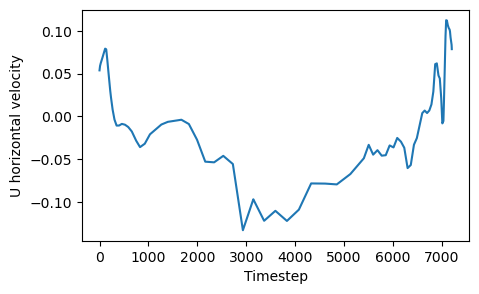

In [11]:
plt.figure(figsize=(5, 3))
df = pd.read_csv("./data/data_bottom_pause_U_nolatlon.csv")
plt.plot(df.index,df.U)
plt.xlabel('Timestep')
plt.ylabel('U horizontal velocity')
plt.savefig('./figures/ecco-u-profile')

# reset kernel

In [2]:
model = llcreader.ECCOPortalLLC2160Model()
ds = model.get_dataset(varnames=['U','V'], type='latlon')
subset2 = ds.isel(time=-1,j=slice(4645,4655),j_g=slice(4645,4655),i=slice(7640,7650),i_g=slice(7640,7650),k=slice(0,50))
array2 = xr.DataArray(subset2.V.data,dims=['depth','lat','lon'],coords={'depth':subset2.Z.data,'lat':subset2.YC[:,0].data,'lon':subset2.XC[0,:].data})

down_data = array2.sel(lat=25.6,lon= -79.48,method='nearest').load()
down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=25.6,lon=-79.81,method='nearest').load()
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32

i1=0; i2=48;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,5400)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

i1=0; i2=47;
tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

i1=0; i2=101;
tem = down_data2[i1:i2].copy()
depth_new=np.linspace(down_data2.depth[-1].data,up_data2.depth[-1].data,101)
#temp_new=np.linspace(down_lowest,up_lowest.data,101)
temp_new=np.linspace(down_lowest,up_lowest,101)
middle_data = tem
middle_data['depth']=depth_new #set depth all to deepest point
middle_data[:]=temp_new #set temp to lowest temp

data_bottom_pause = xr.concat(
    [down_data2,middle_data,up_data2.isel(depth=slice(None, None, -1))],
    dim='depth')


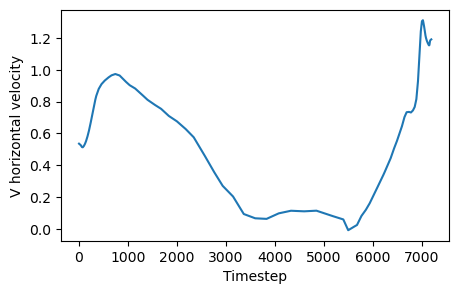

In [3]:
df = data_bottom_pause.to_dataframe()
# Find columns that contain the string 'getitem'
matching_columns = [col for col in df.columns if 'getitem' in col]
df = df.rename(columns={matching_columns[0]:'V'})
df['depth']=df.index
#df['timestep'] = np.arange(7200)
df.index=np.arange(7200)
df.index.name = 'timestep'
df = df[['depth','V', 'lat', 'lon']]
del df['lat']
del df['lon']
#save data
df.to_csv("./data/data_bottom_pause_V_nolatlon.csv")

plt.figure(figsize=(5, 3))
df = pd.read_csv("./data/data_bottom_pause_V_nolatlon.csv")
plt.plot(df.index,df.V)
plt.xlabel('Timestep')
plt.ylabel('V horizontal velocity')
plt.savefig('./figures/ecco-v-profile')

# now do W?

In [8]:
model = llcreader.ECCOPortalLLC2160Model()
ds = model.get_dataset(varnames=['W'], type='latlon')
subset2 = ds.isel(time=-1,j=slice(4645,4655),j_g=slice(4645,4655),i=slice(7640,7650),i_g=slice(7640,7650),k=slice(0,50),k_u=slice(0,50),k_l=slice(0,50),k_p1=slice(0,50))
array2 = xr.DataArray(subset2.W.data,dims=['depth','lat','lon'],coords={'depth':subset2.Z.data,'lat':subset2.YC[:,0].data,'lon':subset2.XC[0,:].data})

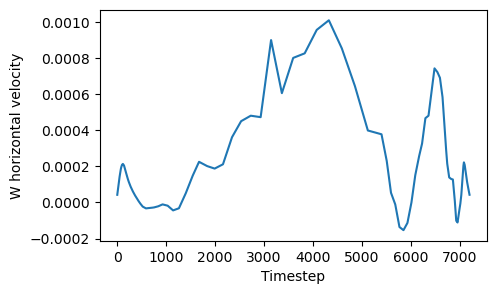

In [12]:
down_data = array2.sel(lat=25.6,lon= -79.48,method='nearest').load()
down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=25.6,lon=-79.81,method='nearest').load()
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32

i1=0; i2=48;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,5400)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

i1=0; i2=47;
tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

i1=0; i2=101;
tem = down_data2[i1:i2].copy()
depth_new=np.linspace(down_data2.depth[-1].data,up_data2.depth[-1].data,101)
#temp_new=np.linspace(down_lowest,up_lowest.data,101)
temp_new=np.linspace(down_lowest,up_lowest,101)
middle_data = tem
middle_data['depth']=depth_new #set depth all to deepest point
middle_data[:]=temp_new #set temp to lowest temp

data_bottom_pause = xr.concat(
    [down_data2,middle_data,up_data2.isel(depth=slice(None, None, -1))],
    dim='depth')
df = data_bottom_pause.to_dataframe()
# Find columns that contain the string 'getitem'
matching_columns = [col for col in df.columns if 'getitem' in col]
df = df.rename(columns={matching_columns[0]:'W'})
df['depth']=df.index
#df['timestep'] = np.arange(7200)
df.index=np.arange(7200)
df.index.name = 'timestep'
#df = df[['timestep', 'depth','Theta', 'lat', 'lon']]
df = df[['depth','W', 'lat', 'lon']]
del df['lat']
del df['lon']
#save data
df.to_csv("./data/data_bottom_pause_W_nolatlon.csv")
df

plt.figure(figsize=(5, 3))
df = pd.read_csv("./data/data_bottom_pause_W_nolatlon.csv")
plt.plot(df.index,df.W)
plt.xlabel('Timestep')
plt.ylabel('W horizontal velocity')
plt.savefig('./figures/ecco-w-profile')

In [1]:
import pandas as pd
df = pd.read_csv("./data/data_bottom_pause_ThetaSalt_nolatlon.csv")
df2 = pd.read_csv("./data/data_bottom_pause_U_nolatlon.csv")
df['U'] = df2['U']
df2 = pd.read_csv("./data/data_bottom_pause_V_nolatlon.csv")
df['V'] = df2['V']
df2 = pd.read_csv("./data/data_bottom_pause_W_nolatlon.csv")
df['W'] = df2['W']
df.to_csv("./data/data_bottom_pause_ThetaSaltUVW_nolatlon.csv")